In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append("C:/Users/w510663/Desktop/Pyri/connections/")
from conn import snowflake_conn

conn = snowflake_conn()
cur = conn.cursor()

cur.execute('''
    SELECT DISTINCT FE.CUST_ID, FE.SETID, FE.REF_DATE, FE.A_NAICS_2_DIGIT_C, FE.A_TENURE_MONTHS_N, FE.A_FLAG_REVOLVER_B, FE.A_YEARS_IN_BUSINESS_APP_N, FE.A_FLEET_SIZE_APP_N,
        FE.D_SPREAD_EXPOSURE_6M_N, FE.D_MAX_DAYS_PAST_DUE_6M_N, FE.D_MAX_EXPOSURE_1M_N, FE.D_DAYS_SINCE_LAST_SUSPENSION_CURRENT_N, FE.D_DAYS_SINCE_LAST_30DPD_CURRENT_N, 
        FE.D_DAYS_PAST_DUE_CURRENT_N, FE.D_SPREAD_FRAC_UNBILLED_6M_N, FE.D_MAX_FRAC_UNBILLED_1M_N, FE.D_MAX_DAYS_PAST_DUE_1M_N,
        FE.DNB_COMMERCIAL_CREDIT_SCORE_CURRENT_N, FE.DNB_FINANCIAL_STRESS_SCORE_CURRENT_N,
        FE.LN_LEXISNEXIS_SCORE_CURRENT_N, FE.LN_LEXISNEXIS_SBFE_SCORE_CURRENT_N,
        FE.T_TOTAL_TRX_NON_FUEL_PROPORTION_1M_N, FE.T_SPREAD_GROSS_SPEND_6M_N, FE.T_SPREAD_TOTAL_TRX_6M_N, FE.T_SUM_GALLONS_1M_N, FE.T_SPREAD_SUM_GALLONS_6M_N,
        FE.FLAG_60_DPD_366_DAYS,
        FL.EXCL_PORTFOLIO_FLAG, FL.EXCL_CUST_STATUS_FLAG, FL.EXCL_CUST_TENURE_FLAG, FL.EXCL_GOV_VIP_FLAG, FL.EXCL_DUMMY_CREDIT_LIMIT_FLAG, FL.EXCL_LARGE_CREDIT_LIMIT_FLAG,
        FL.EXCL_MATERIAL_DELINQUENCY_FLAG, FL.EXCL_CUST_CONVERSION_FLAG, FL.EXCL_FRAUD_FLAG, FL.EXCL_EFPS_FLAG,
        L0.WX_CUST_SUSP_CLASS, L0.GOVERNMENT_FLG
        -- P.MODEL_PROB
    FROM DATAIKU_RAW_SUB.RISK_FRAUD.PM_FEATURE_TABLE FE
    LEFT JOIN DATAIKU_RAW_SUB.RISK_FRAUD.PM_STAGE_L1_CUSTOMER_FILTER_FLAGS_PERSIST FL
        ON FE.CUST_ID = FL.CUST_ID AND FE.REF_DATE = FL.REF_DATE AND FE.SETID = FL.SETID
    LEFT JOIN DATAIKU_RAW_SUB.RISK_FRAUD.PM_STAGE_L0_CUSTOMER_FILTER_ATTRIBUTES_PERSIST L0
        ON FE.CUST_ID = L0.CUST_ID AND FE.REF_DATE = L0.REF_DATE AND FE.SETID = L0.SETID
    -- LEFT JOIN DATAIKU_RAW_SUB.RISK_FRAUD.PM_NAF_OUTPUT_RISK_MODEL P --SHAP for each feature can be extract here
    -- ON FE.CUST_ID = P.CUST_ID AND FE.REF_DATE = P.REF_DATE AND FE.SETID = P.SETID
    WHERE FE.REF_DATE >= '2021-01-01' AND FE.REF_DATE <= '2022-08-01'
    -- AND GREATEST(FL.EXCL_PORTFOLIO_FLAG, FL.EXCL_CUST_STATUS_FLAG, FL.EXCL_CUST_TENURE_FLAG, FL.EXCL_DUMMY_CREDIT_LIMIT_FLAG, FL.EXCL_LARGE_CREDIT_LIMIT_FLAG,
    --  FL.EXCL_MATERIAL_DELINQUENCY_FLAG, FL.EXCL_CUST_CONVERSION_FLAG, FL.EXCL_FRAUD_FLAG, FL.EXCL_EFPS_FLAG) = 0
;
''')
all_acct = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])
all_acct.shape

c:\Users\w510663\Anaconda3\lib\site-packages\snowflake\connector\options.py:108: UserWarning: You have an incompatible version of 'pyarrow' installed (11.0.0), please install a version that adheres to: 'pyarrow<10.1.0,>=10.0.1; extra == "pandas"'
  warn_incompatible_dep(
Failed to import ArrowResult. No Apache Arrow result set format can be used. ImportError: DLL load failed while importing arrow_iterator: The specified procedure could not be found.


(7008202, 39)

### **Accounts with GOV / VIP Flag** - WITH and WITHOUT Other Flags

In [16]:
df_gov_vip = all_acct.copy()

# Create a column called 'EXCL_CRITERIA_SUM' to sum up all exclusion criteria
df_gov_vip['EXCL_CRITERIA_SUM'] = \
    df_gov_vip.EXCL_PORTFOLIO_FLAG \
    + df_gov_vip.EXCL_CUST_STATUS_FLAG \
    + df_gov_vip.EXCL_CUST_TENURE_FLAG \
    + df_gov_vip.EXCL_GOV_VIP_FLAG \
    + df_gov_vip.EXCL_DUMMY_CREDIT_LIMIT_FLAG \
    + df_gov_vip.EXCL_LARGE_CREDIT_LIMIT_FLAG \
    + df_gov_vip.EXCL_MATERIAL_DELINQUENCY_FLAG \
    + df_gov_vip.EXCL_CUST_CONVERSION_FLAG \
    + df_gov_vip.EXCL_FRAUD_FLAG \
    + df_gov_vip.EXCL_EFPS_FLAG

df_gov_vip['IN_MODEL'] = np.where((df_gov_vip.EXCL_CRITERIA_SUM == 0), 1, 0)
df_gov_vip['EXCL_FROM_MODEL'] = np.where((df_gov_vip.EXCL_CRITERIA_SUM > 0), 1, 0)

# Create a column called 'EXCL_GOV_VIP_FLAG_ONLY' where EXCL_GOV_VIP_FLAG = 1 and EXCL_CRITERIA_SUM = 1
df_gov_vip['GOV_VIP_FLAG_ONLY'] = np.where((df_gov_vip.EXCL_GOV_VIP_FLAG == 1) & (df_gov_vip.EXCL_CRITERIA_SUM == 1), 1, 0)

# Create a column called 'EXCL_ONLY_GOV_VIP_FLAG' where EXCL_GOV_VIP_FLAG = 1 and EXCL_CRITERIA_SUM > 1
df_gov_vip['GOV_VIP_FLAG_WITH_OTHERS'] = np.where((df_gov_vip.EXCL_GOV_VIP_FLAG == 1) & (df_gov_vip.EXCL_CRITERIA_SUM > 1), 1, 0)

# Create a dataframe for CUST_ID count for each ref_date for EXCL_GOV_VIP_FLAG_ONLY and EXCL_GOV_VIP_FLAG_WITH_OTHERS
df_gov_vip = df_gov_vip.groupby('REF_DATE').agg({'CUST_ID': 'nunique', 'IN_MODEL': 'sum', 'EXCL_FROM_MODEL': 'sum', 'GOV_VIP_FLAG_ONLY': 'sum', 'GOV_VIP_FLAG_WITH_OTHERS': 'sum'}).reset_index()
df_gov_vip['GOV_VIP_FLAG_ONLY_PERCENT'] = df_gov_vip['GOV_VIP_FLAG_ONLY'] / df_gov_vip['CUST_ID']
df_gov_vip['GOV_VIP_FLAG_WITH_OTHERS_PERCENT'] = df_gov_vip['GOV_VIP_FLAG_WITH_OTHERS'] / df_gov_vip['CUST_ID']

df_gov_vip = df_gov_vip[['REF_DATE', 'CUST_ID', 'IN_MODEL', 'EXCL_FROM_MODEL', 'GOV_VIP_FLAG_ONLY', 'GOV_VIP_FLAG_ONLY_PERCENT', 'GOV_VIP_FLAG_WITH_OTHERS', 'GOV_VIP_FLAG_WITH_OTHERS_PERCENT']]
df_gov_vip

,REF_DATE,CUST_ID,IN_MODEL,EXCL_FROM_MODEL,GOV_VIP_FLAG_ONLY,GOV_VIP_FLAG_ONLY_PERCENT,GOV_VIP_FLAG_WITH_OTHERS,GOV_VIP_FLAG_WITH_OTHERS_PERCENT
0,2021-03-01,520483,300531,219952,14847,0.028525,17901,0.034393
1,2021-06-01,537163,298991,238172,14971,0.027870,18228,0.033934
2,2021-09-01,555096,313032,242064,15431,0.027799,18368,0.033090
3,2021-12-01,579898,322219,257679,15970,0.027539,17939,0.030935
4,2022-01-01,585767,322176,263591,16054,0.027407,18013,0.030751
5,2022-02-01,590508,321454,269054,16014,0.027119,18354,0.031082
6,2022-03-01,597779,321022,276757,15977,0.026727,19405,0.032462
7,2022-04-01,601395,323730,277665,15480,0.025740,19292,0.032079
8,2022-05-01,603232,323616,279616,16450,0.027270,19162,0.031766
9,2022-06-01,606192,325077,281115,17330,0.028588,18353,0.030276


### **Accounts with GOV / VIP Flag Only** - NOT with other exclusion flags

In [22]:
df_wx_cust_susp_class = all_acct.copy()

df_wx_cust_susp_class['EXCL_CRITERIA_SUM'] = \
    df_wx_cust_susp_class.EXCL_PORTFOLIO_FLAG \
    + df_wx_cust_susp_class.EXCL_CUST_STATUS_FLAG \
    + df_wx_cust_susp_class.EXCL_CUST_TENURE_FLAG \
    + df_wx_cust_susp_class.EXCL_GOV_VIP_FLAG \
    + df_wx_cust_susp_class.EXCL_DUMMY_CREDIT_LIMIT_FLAG \
    + df_wx_cust_susp_class.EXCL_LARGE_CREDIT_LIMIT_FLAG \
    + df_wx_cust_susp_class.EXCL_MATERIAL_DELINQUENCY_FLAG \
    + df_wx_cust_susp_class.EXCL_CUST_CONVERSION_FLAG \
    + df_wx_cust_susp_class.EXCL_FRAUD_FLAG \
    + df_wx_cust_susp_class.EXCL_EFPS_FLAG

df_wx_cust_susp_class['IN_MODEL'] = np.where((df_wx_cust_susp_class.EXCL_CRITERIA_SUM == 0), 1, 0)
# Get % of FLAG_60_DPD_366_DAYS = 1 where IN_MODEL = 1
df_wx_cust_susp_class['IN_MODEL_DEFAULT'] = np.where((df_wx_cust_susp_class.FLAG_60_DPD_366_DAYS == 1) & (df_wx_cust_susp_class.IN_MODEL == 1), 1, 0)

# Create a column called 'EXCL_GOV_VIP_FLAG_ONLY' where EXCL_GOV_VIP_FLAG = 1 and EXCL_CRITERIA_SUM = 1
df_wx_cust_susp_class['GOV_FLAG_ONLY'] = np.where((df_wx_cust_susp_class.EXCL_GOV_VIP_FLAG == 1) 
                                                       & ((df_wx_cust_susp_class.WX_CUST_SUSP_CLASS == 'G') | (df_wx_cust_susp_class.GOVERNMENT_FLG == 'Y'))
                                                       & (df_wx_cust_susp_class.EXCL_CRITERIA_SUM == 1), 1, 0)
df_wx_cust_susp_class['GOV_FLAG_DEFAULT'] = np.where((df_wx_cust_susp_class.FLAG_60_DPD_366_DAYS == 1) & (df_wx_cust_susp_class.GOV_FLAG_ONLY == 1), 1, 0)

df_wx_cust_susp_class['VIP_FLAG_ONLY'] = np.where((df_wx_cust_susp_class.EXCL_GOV_VIP_FLAG == 1) 
                                                       & ((df_wx_cust_susp_class.WX_CUST_SUSP_CLASS == 'V') & (df_wx_cust_susp_class.GOVERNMENT_FLG != 'Y'))
                                                       & (df_wx_cust_susp_class.EXCL_CRITERIA_SUM == 1), 1, 0)
df_wx_cust_susp_class['VIP_FLAG_DEFAULT'] = np.where((df_wx_cust_susp_class.FLAG_60_DPD_366_DAYS == 1) & (df_wx_cust_susp_class.VIP_FLAG_ONLY == 1), 1, 0)

df_wx_cust_susp_class['E_FLAG_ONLY'] = np.where((df_wx_cust_susp_class.EXCL_GOV_VIP_FLAG == 1) 
                                                       & ((df_wx_cust_susp_class.WX_CUST_SUSP_CLASS == 'E') & (df_wx_cust_susp_class.GOVERNMENT_FLG != 'Y'))
                                                       & (df_wx_cust_susp_class.EXCL_CRITERIA_SUM == 1), 1, 0)
df_wx_cust_susp_class['E_FLAG_DEFAULT'] = np.where((df_wx_cust_susp_class.FLAG_60_DPD_366_DAYS == 1) & (df_wx_cust_susp_class.E_FLAG_ONLY == 1), 1, 0)

df_wx_cust_susp_class['K_FLAG_ONLY'] = np.where((df_wx_cust_susp_class.EXCL_GOV_VIP_FLAG == 1) 
                                                       & ((df_wx_cust_susp_class.WX_CUST_SUSP_CLASS == 'K') & (df_wx_cust_susp_class.GOVERNMENT_FLG != 'Y'))
                                                       & (df_wx_cust_susp_class.EXCL_CRITERIA_SUM == 1), 1, 0)
df_wx_cust_susp_class['K_FLAG_DEFAULT'] = np.where((df_wx_cust_susp_class.FLAG_60_DPD_366_DAYS == 1) & (df_wx_cust_susp_class.K_FLAG_ONLY == 1), 1, 0)

df_wx_cust_susp_class = df_wx_cust_susp_class.groupby('REF_DATE').agg({'CUST_ID': 'nunique'
                                                                       , 'IN_MODEL': 'sum'
                                                                       , 'IN_MODEL_DEFAULT': 'sum'
                                                                       , 'GOV_FLAG_ONLY': 'sum'
                                                                       , 'GOV_FLAG_DEFAULT': 'sum'
                                                                       , 'VIP_FLAG_ONLY': 'sum'
                                                                       , 'VIP_FLAG_DEFAULT': 'sum'
                                                                       , 'E_FLAG_ONLY': 'sum'
                                                                       , 'E_FLAG_DEFAULT': 'sum'
                                                                       , 'K_FLAG_ONLY': 'sum'
                                                                       , 'K_FLAG_DEFAULT': 'sum'}).reset_index()

# Create a column for IN_MODEL_DEFAULT / IN_MODEL
df_wx_cust_susp_class['IN_MODEL_DEFAULT_RATE'] = df_wx_cust_susp_class['IN_MODEL_DEFAULT'] / df_wx_cust_susp_class['IN_MODEL']
df_wx_cust_susp_class['GOV_FLAG_DEFAULT_RATE'] = df_wx_cust_susp_class['GOV_FLAG_DEFAULT'] / df_wx_cust_susp_class['GOV_FLAG_ONLY']
df_wx_cust_susp_class['VIP_FLAG_DEFAULT_RATE'] = df_wx_cust_susp_class['VIP_FLAG_DEFAULT'] / df_wx_cust_susp_class['VIP_FLAG_ONLY']
df_wx_cust_susp_class['E_FLAG_DEFAULT_RATE'] = df_wx_cust_susp_class['E_FLAG_DEFAULT'] / df_wx_cust_susp_class['E_FLAG_ONLY']
df_wx_cust_susp_class['K_FLAG_DEFAULT_RATE'] = df_wx_cust_susp_class['K_FLAG_DEFAULT'] / df_wx_cust_susp_class['K_FLAG_ONLY']

df_wx_cust_susp_class = df_wx_cust_susp_class[['REF_DATE', 'CUST_ID', 'IN_MODEL', 'IN_MODEL_DEFAULT_RATE', 'GOV_FLAG_ONLY', 'GOV_FLAG_DEFAULT_RATE', 'VIP_FLAG_ONLY', 'VIP_FLAG_DEFAULT_RATE', 'E_FLAG_ONLY', 'E_FLAG_DEFAULT_RATE', 'K_FLAG_ONLY', 'K_FLAG_DEFAULT_RATE']]
df_wx_cust_susp_class

,REF_DATE,CUST_ID,IN_MODEL,IN_MODEL_DEFAULT_RATE,GOV_FLAG_ONLY,GOV_FLAG_DEFAULT_RATE,VIP_FLAG_ONLY,VIP_FLAG_DEFAULT_RATE,E_FLAG_ONLY,E_FLAG_DEFAULT_RATE,K_FLAG_ONLY,K_FLAG_DEFAULT_RATE
0,2021-03-01,520483,300531,0.028896,12683,0.039107,117,0.085470,695,0.001439,1352,0.010355
1,2021-06-01,537163,298991,0.036757,12778,0.042808,118,0.059322,719,0.001391,1356,0.008850
2,2021-09-01,555096,313032,0.051749,13141,0.045050,114,0.061404,748,0.001337,1428,0.009804
3,2021-12-01,579898,322219,0.063596,13607,0.047917,116,0.112069,764,0.002618,1483,0.011463
4,2022-01-01,585767,322176,0.067292,13698,0.050737,120,0.116667,762,0.003937,1474,0.011533
5,2022-02-01,590508,321454,0.069139,13648,0.048652,115,0.078261,765,0.003922,1486,0.012786
6,2022-03-01,597779,321022,0.069768,13605,0.048512,112,0.080357,758,0.003958,1502,0.012650
7,2022-04-01,601395,323730,0.069765,13802,0.050500,121,0.090909,34,0.000000,1523,0.013132
8,2022-05-01,603232,323616,0.070476,13978,0.050508,122,0.106557,769,0.002601,1581,0.012018
9,2022-06-01,606192,325077,0.071029,14047,0.048409,915,0.013115,778,0.003856,1590,0.011950


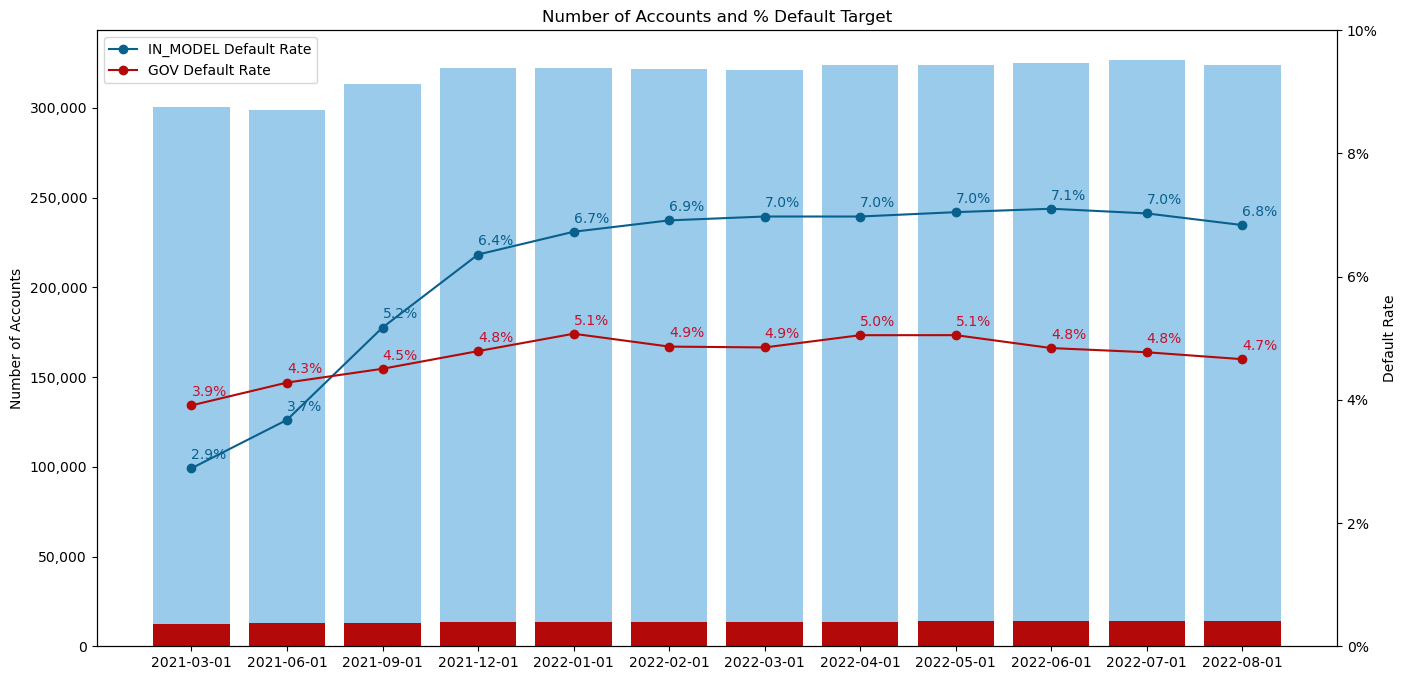

In [55]:
fig, ax1 = plt.subplots(figsize=(16, 8))

ax2 = ax1.twinx()
# Make REF_DATE discrete
ax1.bar(df_wx_cust_susp_class.REF_DATE.astype(str), df_wx_cust_susp_class.IN_MODEL, color='#9bcbeb')
ax2.plot(df_wx_cust_susp_class.REF_DATE.astype(str), df_wx_cust_susp_class.IN_MODEL_DEFAULT_RATE * 100, color='#08608c', marker='o', label='IN_MODEL Default Rate')

ax1.bar(df_wx_cust_susp_class.REF_DATE.astype(str), df_wx_cust_susp_class.GOV_FLAG_ONLY, color='#b30909')
ax2.plot(df_wx_cust_susp_class.REF_DATE.astype(str), df_wx_cust_susp_class.GOV_FLAG_DEFAULT_RATE * 100, color='#b30909', marker='o', label='GOV Default Rate')

# data label on ax2 as percent with 1 decimal place
for i, v in enumerate(df_wx_cust_susp_class.IN_MODEL_DEFAULT_RATE):
    ax2.text(i, v * 100 + .1, "{:.1f}%".format(v * 100), color='#08608c', ha='left', va='bottom')
for i, v in enumerate(df_wx_cust_susp_class.GOV_FLAG_DEFAULT_RATE):
    ax2.text(i, v * 100 + .1, "{:.1f}%".format(v * 100), color='#c8102e', ha='left', va='bottom')

ax1.set_ylabel('Number of Accounts')
# y label format as number with comma
ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax2.set_ylabel('Default Rate')
# y label format as percent with 0 decimal place
ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}%".format(x)))
ax2.set_ylim(0,10)

plt.title('Number of Accounts and % Default Target')
plt.legend(loc='upper left')
plt.show()

In [63]:
df = all_acct.copy()

# Create a column called 'EXCL_CRITERIA_SUM' to sum up all exclusion criteria
df['EXCL_CRITERIA_SUM'] = \
    df.EXCL_PORTFOLIO_FLAG \
    + df.EXCL_CUST_STATUS_FLAG \
    + df.EXCL_CUST_TENURE_FLAG \
    + df.EXCL_GOV_VIP_FLAG \
    + df.EXCL_DUMMY_CREDIT_LIMIT_FLAG \
    + df.EXCL_LARGE_CREDIT_LIMIT_FLAG \
    + df.EXCL_MATERIAL_DELINQUENCY_FLAG \
    + df.EXCL_CUST_CONVERSION_FLAG \
    + df.EXCL_FRAUD_FLAG \
    + df.EXCL_EFPS_FLAG

df['IN_MODEL'] = np.where((df.EXCL_CRITERIA_SUM == 0), 1, 0)
df['EXCL_FROM_MODEL'] = np.where((df.EXCL_CRITERIA_SUM > 0), 1, 0)

# Create a column called 'EXCL_GOV_VIP_FLAG_ONLY' where EXCL_GOV_VIP_FLAG = 1 and EXCL_CRITERIA_SUM = 1
df['GOV_VIP_FLAG_ONLY'] = np.where((df.EXCL_GOV_VIP_FLAG == 1) & (df.EXCL_CRITERIA_SUM == 1), 1, 0)

# Create a column called 'EXCL_ONLY_GOV_VIP_FLAG' where EXCL_GOV_VIP_FLAG = 1 and EXCL_CRITERIA_SUM > 1
df['GOV_VIP_FLAG_WITH_OTHERS'] = np.where((df.EXCL_GOV_VIP_FLAG == 1) & (df.EXCL_CRITERIA_SUM > 1), 1, 0)

# Create a G,V,E,K flag
df['GOV_FLAG_ONLY'] = np.where((df.EXCL_GOV_VIP_FLAG == 1) 
                               & ((df.WX_CUST_SUSP_CLASS == 'G') | (df.GOVERNMENT_FLG == 'Y'))
                               & (df.EXCL_CRITERIA_SUM == 1), 1, 0)

df['VIP_FLAG_ONLY'] = np.where((df.EXCL_GOV_VIP_FLAG == 1)
                               & ((df.WX_CUST_SUSP_CLASS == 'V') & (df.GOVERNMENT_FLG != 'Y'))
                               & (df.EXCL_CRITERIA_SUM == 1), 1, 0)

df['E_FLAG_ONLY'] = np.where((df.EXCL_GOV_VIP_FLAG == 1) 
                             & ((df.WX_CUST_SUSP_CLASS == 'E') & (df.GOVERNMENT_FLG == 'Y'))
                             & (df.EXCL_CRITERIA_SUM == 1), 1, 0)

df['K_FLAG_ONLY'] = np.where((df.EXCL_GOV_VIP_FLAG == 1) 
                             & ((df.WX_CUST_SUSP_CLASS == 'K') & (df.GOVERNMENT_FLG == 'Y'))
                             & (df.EXCL_CRITERIA_SUM == 1), 1, 0)


In [64]:
df.head()

,CUST_ID,SETID,REF_DATE,A_NAICS_2_DIGIT_C,A_TENURE_MONTHS_N,A_FLAG_REVOLVER_B,A_YEARS_IN_BUSINESS_APP_N,A_FLEET_SIZE_APP_N,D_SPREAD_EXPOSURE_6M_N,D_MAX_DAYS_PAST_DUE_6M_N,...,GOVERNMENT_FLG,EXCL_CRITERIA_SUM,IN_MODEL,EXCL_FROM_MODEL,GOV_VIP_FLAG_ONLY,GOV_VIP_FLAG_WITH_OTHERS,GOV_FLAG_ONLY,VIP_FLAG_ONLY,E_FLAG_ONLY,K_FLAG_ONLY
0,9100008400402,WXB,2022-04-01,Un,20,0,2.0,2.0,0E-8,452.000,...,N,2,0,1,0,0,0,0,0,0
1,9100001219428,FSC,2022-07-01,23,138,0,NaN,NaN,0.82696758,32.000,...,N,0,1,0,0,0,0,0,0,0
2,0457004603536,FSC,2022-04-01,44,61,0,NaN,NaN,0.25665294,3.000,...,N,0,1,0,0,0,0,0,0,0
3,9100006896646,CHV,2022-07-01,23,43,0,NaN,NaN,0.75406634,0.000,...,N,0,1,0,0,0,0,0,0,0
4,0444007326408,FSC,2022-07-01,Un,189,0,NaN,NaN,0E-8,999.000,...,N,2,0,1,0,0,0,0,0,0


In [107]:
feature_list = ['A_NAICS_2_DIGIT_C', 'A_TENURE_MONTHS_N', 'A_FLAG_REVOLVER_B', 'A_YEARS_IN_BUSINESS_APP_N',
       'A_FLEET_SIZE_APP_N', 'D_SPREAD_EXPOSURE_6M_N',
       'D_MAX_DAYS_PAST_DUE_6M_N', 'D_MAX_EXPOSURE_1M_N', 'D_DAYS_SINCE_LAST_SUSPENSION_CURRENT_N', 'D_DAYS_SINCE_LAST_30DPD_CURRENT_N',
       'D_DAYS_PAST_DUE_CURRENT_N', 'D_SPREAD_FRAC_UNBILLED_6M_N', 'D_MAX_FRAC_UNBILLED_1M_N', 'D_MAX_DAYS_PAST_DUE_1M_N',
       'DNB_COMMERCIAL_CREDIT_SCORE_CURRENT_N', 'DNB_FINANCIAL_STRESS_SCORE_CURRENT_N', 'LN_LEXISNEXIS_SCORE_CURRENT_N', 'LN_LEXISNEXIS_SBFE_SCORE_CURRENT_N',
       'T_TOTAL_TRX_NON_FUEL_PROPORTION_1M_N', 'T_SPREAD_GROSS_SPEND_6M_N', 'T_SPREAD_TOTAL_TRX_6M_N', 'T_SUM_GALLONS_1M_N', 'T_SPREAD_SUM_GALLONS_6M_N'
]

Text(0.5, 1.0, 'K_FLAG_ONLY Accounts')

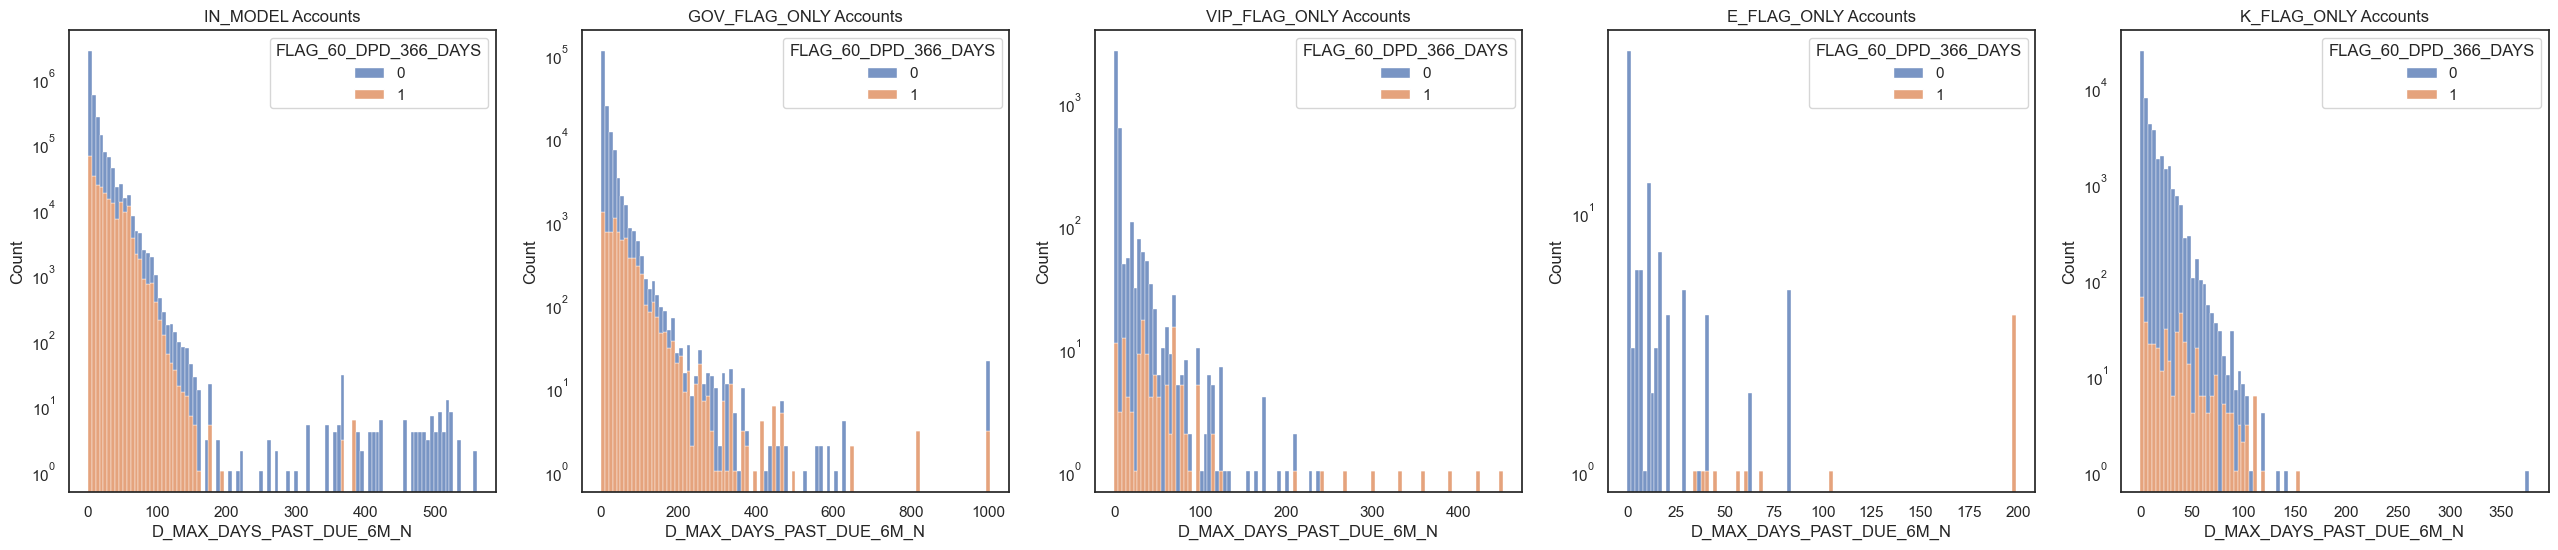

In [110]:
feature = 'D_MAX_DAYS_PAST_DUE_6M_N'

fig,axs = plt.subplots(1,5, figsize = (32,6))

sns.histplot(data=df[df.IN_MODEL == 1], x=feature, hue='FLAG_60_DPD_366_DAYS', multiple='stack', bins=100, ax=axs[0])
axs[0].set_yscale('log')
axs[0].set_title('IN_MODEL Accounts')

sns.histplot(data=df[df.GOV_FLAG_ONLY == 1], x=feature, hue='FLAG_60_DPD_366_DAYS', multiple='stack', bins=100, ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_title('GOV_FLAG_ONLY Accounts')

sns.histplot(data=df[df.VIP_FLAG_ONLY == 1], x=feature, hue='FLAG_60_DPD_366_DAYS', multiple='stack', bins=100, ax=axs[2])
axs[2].set_yscale('log')
axs[2].set_title('VIP_FLAG_ONLY Accounts')

sns.histplot(data=df[df.E_FLAG_ONLY == 1], x=feature, hue='FLAG_60_DPD_366_DAYS', multiple='stack', bins=100, ax=axs[3])
axs[3].set_yscale('log')
axs[3].set_title('E_FLAG_ONLY Accounts')

sns.histplot(data=df[df.K_FLAG_ONLY == 1], x=feature, hue='FLAG_60_DPD_366_DAYS', multiple='stack', bins=100, ax=axs[4])
axs[4].set_yscale('log')
axs[4].set_title('K_FLAG_ONLY Accounts')

Text(0.5, 1.0, 'VIP_FLAGS Accounts')

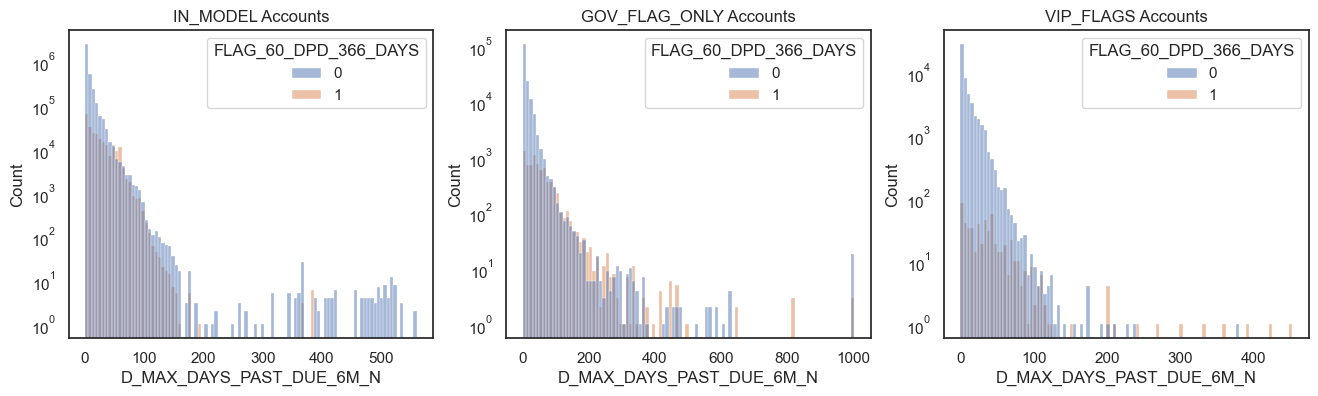

In [116]:
feature = 'D_MAX_DAYS_PAST_DUE_6M_N'

fig,axs = plt.subplots(1,3, figsize = (16,4))

sns.histplot(data=df[df.IN_MODEL == 1], x=feature, hue='FLAG_60_DPD_366_DAYS', multiple='layer', bins=100, ax=axs[0])
axs[0].set_yscale('log')
axs[0].set_title('IN_MODEL Accounts')

sns.histplot(data=df[df.GOV_FLAG_ONLY == 1], x=feature, hue='FLAG_60_DPD_366_DAYS', multiple='layer', bins=100, ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_title('GOV_FLAG_ONLY Accounts')

sns.histplot(data=df[(df.VIP_FLAG_ONLY == 1) | (df.E_FLAG_ONLY == 1) | (df.K_FLAG_ONLY == 1)], x=feature, hue='FLAG_60_DPD_366_DAYS', multiple='layer', bins=100, ax=axs[2])
axs[2].set_yscale('log')
axs[2].set_title('VIP_FLAGS Accounts')